# Predicting Terrorist Attacks
## Perpetrator Classification


### Notebook Configuration

In [2]:
import time
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### Load the Datasets
Load the dataset created by the EDA notebook.

In [4]:
gtd_df = pd.read_csv('../Data/gtd_eda_1997to2017.csv', low_memory=False, index_col = 0,
                      na_values=[''])

In [5]:
# Display a summary of the data frame
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119153 entries, 199601000001 to 201712310032
Data columns (total 48 columns):
iyear               119153 non-null int64
imonth              119153 non-null int64
iday                119153 non-null int64
country_txt         119153 non-null object
region_txt          119153 non-null object
provstate           119153 non-null object
city                119153 non-null object
latitude            119153 non-null float64
longitude           119153 non-null float64
specificity         119153 non-null float64
summary             119153 non-null object
attacktype1_txt     119153 non-null object
targtype1_txt       119153 non-null object
targsubtype1_txt    119153 non-null object
corp1               119153 non-null object
target1             119153 non-null object
natlty1_txt         119153 non-null object
gname               119153 non-null object
nperpcap            119153 non-null float64
weaptype1_txt       119153 non-null object
weapsubtype

### Convert Attributes to Correct Data Type
Convert a subset of the data frame attributes to categorical, datatime and string to align with the GTD code book as executed previously in the EDA notebook.

In [6]:
# List of attributes that are categorical
cat_attrs = ['extended_txt', 'country_txt', 'region_txt', 'specificity', 'vicinity_txt',
             'crit1_txt', 'crit2_txt', 'crit3_txt', 'doubtterr_txt', 'multiple_txt',
             'success_txt', 'suicide_txt', 'attacktype1_txt', 'targtype1_txt', 
             'targsubtype1_txt', 'natlty1_txt', 'guncertain1_txt', 'individual_txt', 
             'claimed_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'property_txt', 
             'ishostkid_txt', 'INT_LOG_txt', 'INT_IDEO_txt','INT_MISC_txt', 'INT_ANY_txt']

for cat in cat_attrs:
    gtd_df[cat] = gtd_df[cat].astype('category')

# Data time feature added during EDA
gtd_df['incident_date'] = pd.to_datetime(gtd_df['incident_date'])

# Necessary for label encoding below
gtd_df['gname'] = gtd_df['gname'].astype('str')
    
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119153 entries, 199601000001 to 201712310032
Data columns (total 48 columns):
iyear               119153 non-null int64
imonth              119153 non-null int64
iday                119153 non-null int64
country_txt         119153 non-null category
region_txt          119153 non-null category
provstate           119153 non-null object
city                119153 non-null object
latitude            119153 non-null float64
longitude           119153 non-null float64
specificity         119153 non-null category
summary             119153 non-null object
attacktype1_txt     119153 non-null category
targtype1_txt       119153 non-null category
targsubtype1_txt    119153 non-null category
corp1               119153 non-null object
target1             119153 non-null object
natlty1_txt         119153 non-null category
gname               119153 non-null object
nperpcap            119153 non-null float64
weaptype1_txt       119153 non-null categ

### Find the Major Groups
Get the list of terrorist groups that have 20 or more attacks.

In [7]:
# Calculate the number of attacks by group
groups = gtd_df['gname'].value_counts()

# Include groups with at least 20 attacks
groups = groups[groups > 19]

# Exclude unknown groups
#group_list = groups.index[groups.index != 'Unknown']
group_list = groups.index

# Subset the data to major groups
major_groups = gtd_df[gtd_df['gname'].isin(group_list)]

# Display the number of attacks by group
major_groups['gname'].value_counts()

Unknown                                                     62459
Taliban                                                      7454
Islamic State of Iraq and the Levant (ISIL)                  5584
Al-Shabaab                                                   3274
Boko Haram                                                   2408
                                                            ...  
Karbi People's Liberation Tigers (KPLT)                        20
Jundallah (Pakistan)                                           20
Military Council of the Tribal Revolutionaries (MCTR)          20
Revolutionary Armed Forces of Colombia (FARC) dissidents       20
Rohingya extremists                                            20
Name: gname, Length: 227, dtype: int64

### Drop Text and Datetime Attributes
Remove the text and datetime attributes, which will not be used in the models.

In [8]:
major_groups = major_groups.drop(['provstate', 'city', 'summary', 'corp1', 'target1',
                                  'scite1', 'dbsource', 'incident_date'], axis=1)

major_groups.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114355 entries, 199601010001 to 201712310032
Data columns (total 40 columns):
iyear               114355 non-null int64
imonth              114355 non-null int64
iday                114355 non-null int64
country_txt         114355 non-null category
region_txt          114355 non-null category
latitude            114355 non-null float64
longitude           114355 non-null float64
specificity         114355 non-null category
attacktype1_txt     114355 non-null category
targtype1_txt       114355 non-null category
targsubtype1_txt    114355 non-null category
natlty1_txt         114355 non-null category
gname               114355 non-null object
nperpcap            114355 non-null float64
weaptype1_txt       114355 non-null category
weapsubtype1_txt    114355 non-null category
nkill               114355 non-null float64
nkillus             114355 non-null float64
nkillter            114355 non-null float64
nwound              114355 non-nul

### Standardize the Numeric Attributes
Adjust for differences in the range of the numeric attributes.

In [9]:
scaler = preprocessing.RobustScaler()

# List of numeric attributes
scale_attrs = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

# Standardize the attributes in place
major_groups[scale_attrs] = scaler.fit_transform(major_groups[scale_attrs])

# View the transformation
major_groups[scale_attrs].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nperpcap,114355.0,0.094626,1.712535,0.0,0.0,0.0,0.0,406.000000
nkill,114355.0,0.738415,6.048853,-0.5,-0.5,0.0,0.5,784.500000
nkillus,114355.0,0.035573,5.653549,0.0,0.0,0.0,0.0,1360.000000
nkillter,114355.0,0.479734,4.135213,0.0,0.0,0.0,0.0,500.000000
nwound,114355.0,1.160095,13.004461,0.0,0.0,0.0,1.0,2730.333333
nwoundus,114355.0,0.014009,0.703465,0.0,0.0,0.0,0.0,151.000000
nwoundte,114355.0,0.101543,1.469677,0.0,0.0,0.0,0.0,200.000000


### Separate Known and Unknown
Split the major groups into known and unknown.

In [10]:
# Excluded Unknown groups
known_maj_groups = major_groups[gtd_df['gname'] != "Unknown"]
print("Known Major Groups: {}".format(known_maj_groups.shape))

# Only include Unknown groups
unknown_maj_groups = major_groups[gtd_df['gname'] == "Unknown"]
print("Unknown Major Groups: {}".format(unknown_maj_groups.shape))

Known Major Groups: (51896, 40)
Unknown Major Groups: (62459, 40)


### Encode the Target Attribute
Convert the text values of the terrorist groups to an encoded numeric value for the random forest models.

In [11]:
# Create the encoder
le = preprocessing.LabelEncoder()

# Fit the encoder to the target
le.fit(known_maj_groups['gname'])

LabelEncoder()

In [12]:
# View the labels
list(le.classes_)

['Abdullah Azzam Brigades',
 'Abu Sayyaf Group (ASG)',
 'Adan-Abyan Province of the Islamic State',
 'Ahrar al-Sham',
 'Ajnad Misr',
 'Al-Aqsa Martyrs Brigade',
 'Al-Fatah',
 "Al-Gama'at al-Islamiyya (IG)",
 'Al-Naqshabandiya Army',
 'Al-Nusrah Front',
 'Al-Qaida',
 'Al-Qaida in Iraq',
 'Al-Qaida in the Arabian Peninsula (AQAP)',
 'Al-Qaida in the Islamic Maghreb (AQIM)',
 'Al-Shabaab',
 'Albanian extremists',
 'Algerian Islamic Extremists',
 'Allied Democratic Forces (ADF)',
 'Anarchists',
 'Animal Liberation Front (ALF)',
 'Ansar Bayt al-Maqdis (Ansar Jerusalem)',
 'Ansar al-Dine (Mali)',
 'Ansar al-Islam',
 'Ansar al-Sharia (Libya)',
 'Anti-Abortion extremists',
 'Anti-Balaka Militia',
 'Anti-Government extremists',
 'Anti-Muslim extremists',
 'Anti-Semitic extremists',
 'Arakan Rohingya Salvation Army (ARSA)',
 'Armed Islamic Group (GIA)',
 "Asa'ib Ahl al-Haqq",
 'Awami League',
 'Azawad National Liberation Movement (MNLA)',
 'Baloch Liberation Army (BLA)',
 'Baloch Liberation Fron

In [13]:
# View the encoded values for th terrorist group names
label_codes = le.transform(known_maj_groups['gname'])
label_codes

array([119, 186,  55, ...,  14, 144,  40])

In [14]:
# Convert some integers into their category names
list(le.inverse_transform([0, 1, 2, 27]))

['Abdullah Azzam Brigades',
 'Abu Sayyaf Group (ASG)',
 'Adan-Abyan Province of the Islamic State',
 'Anti-Muslim extremists']

### Create Training and Testing Datasets
The original dataset is split into 80% training and 20% testing.

In [16]:
# Seed for reproducible results
seed = 1009

# Predictor variables
X = pd.get_dummies(known_maj_groups.drop(['gname'], axis=1), drop_first=True)

# Labels
y = label_codes

# Create an 80/20 split for training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, stratify = y)

### Random Forest Model
Create the model using 1000 estimators.

In [17]:
start = time.time()

# Create the model
rf1 = RandomForestClassifier(n_estimators = 1000, oob_score = True, n_jobs = -1, random_state = seed)

# Fit it to the training data
rf1.fit(X_train, y_train)

end = time.time()
print("Execution Seconds: {}".format((end - start)))
print("\n")
print(rf1)

Execution Seconds: 357.61090779304504


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=1009, verbose=0,
                       warm_start=False)


### Feature Importance
Display the top 50 features by importance in descending order.

In [18]:
# Get the modified column names with one hot encoding
column_names = list(X_train.columns.values)

# Create a descending sorted list of variables by featur importance
var_imp = sorted(zip(map(lambda x: x, rf1.feature_importances_), column_names), 
             reverse = True)

print("\nFeatures Ranking - Top 50:\n")
for f in var_imp[0:50]:
    print(f)


Features Ranking - Top 50:

(0.09227481061949562, 'longitude')
(0.08526225761381348, 'latitude')
(0.04240647771187467, 'iyear')
(0.028350059542337363, 'region_txt_South Asia')
(0.0225610434086569, 'INT_IDEO_txt_YES')
(0.021717768735376355, 'INT_ANY_txt_YES')
(0.021221319012855924, 'natlty1_txt_Iraq')
(0.020531202356384733, 'country_txt_Iraq')
(0.019323969404739485, 'iday')
(0.019305638086873626, 'region_txt_Middle East & North Africa')
(0.01839973972156768, 'imonth')
(0.018106926573159664, 'country_txt_Somalia')
(0.017303760075125078, 'region_txt_Sub-Saharan Africa')
(0.014650913436029471, 'nkill')
(0.014369902038547018, 'INT_IDEO_txt_UKNOWN')
(0.014133965938194718, 'INT_LOG_txt_UKNOWN')
(0.013782025890210138, 'INT_ANY_txt_UKNOWN')
(0.012840866971567395, 'country_txt_India')
(0.01269294650639753, 'country_txt_Pakistan')
(0.012201028959059806, 'country_txt_Nigeria')
(0.011805755859021739, 'nwound')
(0.011639050177854415, 'natlty1_txt_India')
(0.011482496237147364, 'natlty1_txt_Pakistan

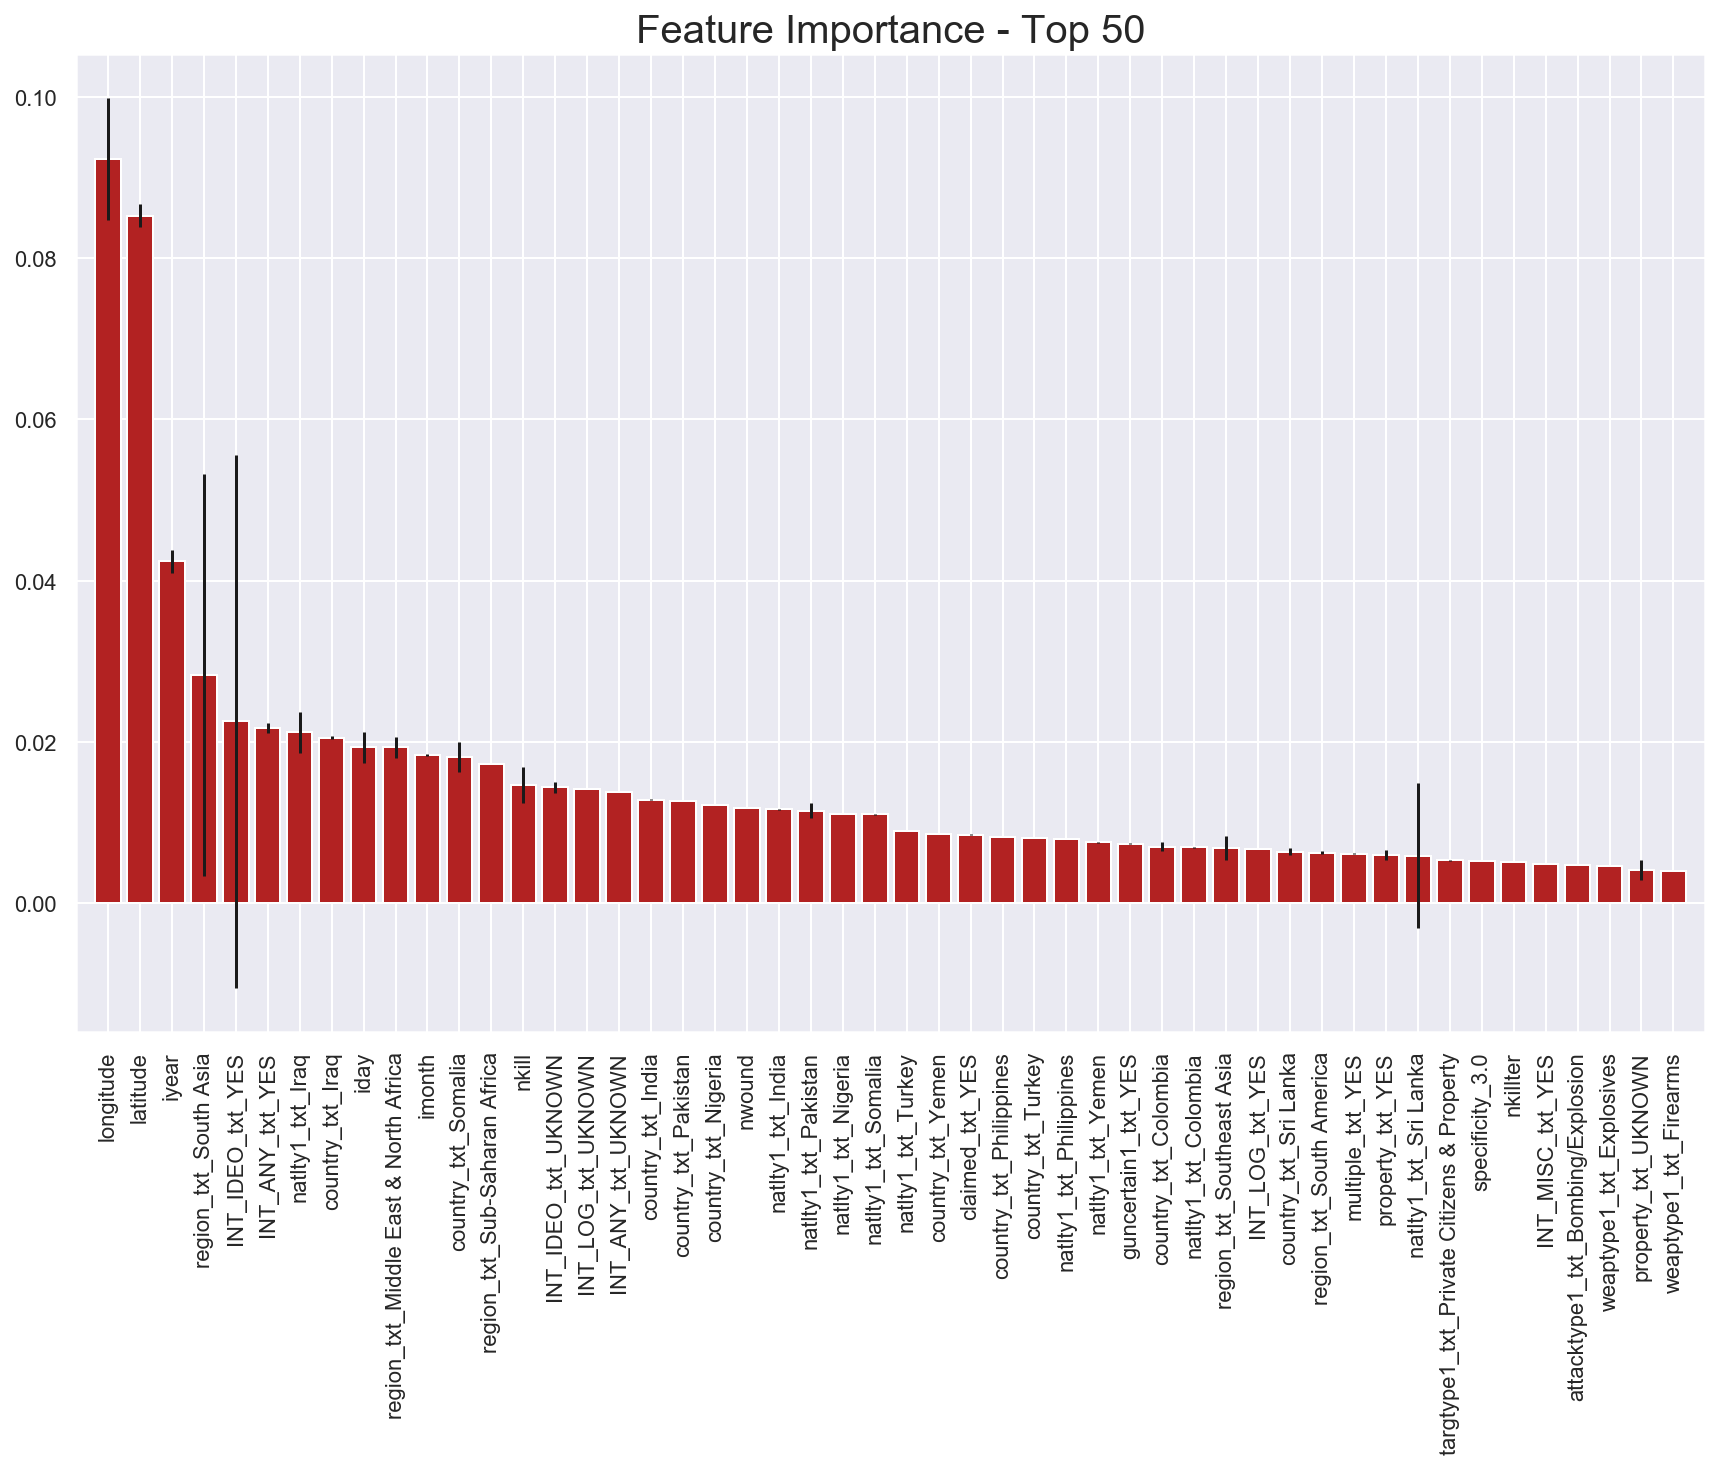

In [19]:
# Get the features, standard deviation and indices
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Filter to the top 50
top_n = 50
top_n_importances = importances[indices][0:top_n]
top_n_std = std[0:top_n]
top_n_indices = indices[0:top_n]

# Create a list of x labels
x_labels = [column_names[t] for t in top_n_indices]

# Plot the results
plt.figure()
plt.title("Feature Importance - Top 50",  fontsize=20)
plt.bar(range(top_n), top_n_importances, color="firebrick", yerr = top_n_std, align="center")
plt.xticks(rotation=90)
plt.xticks(range(top_n), x_labels)
plt.xlim([-1, top_n])
plt.show();

In [23]:
# Predict labels on the test dataset
pred_labels1 = rf1.predict(X_test)

# Calculate the accuracy of the model
acc_score1 = accuracy_score(y_test, pred_labels1)
print("\nAccuracy Score: {}".format(acc_score1*100))

# Calculate the precision of the model
prec_score1 = precision_score(y_test, pred_labels1, average='weighted')
print("\nPrecision Score: {}".format(prec_score1*100))

# Calculate the recall of the model
rcll_score1 = recall_score(y_test, pred_labels1, average='weighted')
print("\nRecall Score: {}".format(rcll_score1*100))

# Calculate the F1 of the model
f1_score1 = f1_score(y_test, pred_labels1, average='weighted')
print("\nF1 Score: {}".format(f1_score1*100))


Accuracy Score: 90.45279383429673

Precision Score: 89.95287972392408

Recall Score: 90.45279383429673

F1 Score: 89.4189908871535


### Apply Model to Unknown Groups

In [26]:
# Predictor variables
X_unknown = pd.get_dummies(unknown_maj_groups.drop(['gname'], axis=1), drop_first=True)


# Predict labels on the unknown dataset
pred_labels2 = rf1.predict(X_unknown)

# Get the list of predicted labels for unknown observations
unknown_preds = list(le.inverse_transform(pred_labels2))

# Calculate the counts for each group
unknown_counts = collections.Counter(unknown_preds)
unknown_counts

Counter({'Gunmen': 8783,
         'Anti-Abortion extremists': 98,
         'Muslim extremists': 28355,
         'Tribesmen': 2768,
         'Rebels': 307,
         'Muslim Militants': 36,
         'Chechen Rebels': 213,
         'Separatists': 3850,
         'Opposition Group': 337,
         'Neo-Nazi extremists': 207,
         'Sunni Muslim extremists': 1486,
         'National Union for the Total Independence of Angola (UNITA)': 11,
         'Left-Wing Guerrillas': 395,
         'Islamist extremists': 705,
         'Fulani extremists': 1027,
         'Militants': 4538,
         'Maoists': 2574,
         'Muslim Separatists': 240,
         'Protestant extremists': 544,
         'Liberation Tigers of Tamil Eelam (LTTE)': 179,
         'Anarchists': 942,
         "New People's Army (NPA)": 478,
         'Paramilitaries': 181,
         'Irish Republican Army (IRA)': 16,
         'National Liberation Army of Colombia (ELN)': 8,
         'Hutu extremists': 13,
         'Palestinian Extremi

### Top 25 Predicted Unknown Groups

In [25]:
# Top 25 unknown
unknown_top25 = pd.DataFrame(unknown_counts.most_common()[0:25], columns=['Group', 'Attacks'])

cumsum = 0

# Display the top 25 groups with counts
for index, row in unknown_top25.iterrows():
    print("{} : {}".format(row['Group'], row['Attacks']))
    cumsum += row['Attacks']


print("\nTop 25 Account For: {}%".format((cumsum / X_unknown.shape[0])*100))

Muslim extremists : 28355
Gunmen : 8783
Militants : 4538
Separatists : 3850
Tribesmen : 2768
Maoists : 2574
Taliban : 2278
Sunni Muslim extremists : 1486
Fulani extremists : 1027
Anarchists : 942
Islamist extremists : 705
Protestant extremists : 544
New People's Army (NPA) : 478
Left-Wing Guerrillas : 395
Opposition Group : 337
Kurdistan Workers' Party (PKK) : 312
Rebels : 307
Muslim Separatists : 240
Al-Shabaab : 225
Chechen Rebels : 213
Neo-Nazi extremists : 207
Paramilitaries : 181
Liberation Tigers of Tamil Eelam (LTTE) : 179
Anti-Muslim extremists : 160
Abu Sayyaf Group (ASG) : 117

Top 25 Account For: 97.98587873645111%


### Muslim Extremists
Almost half of the predicted unknown group observations are Muslim extremists.

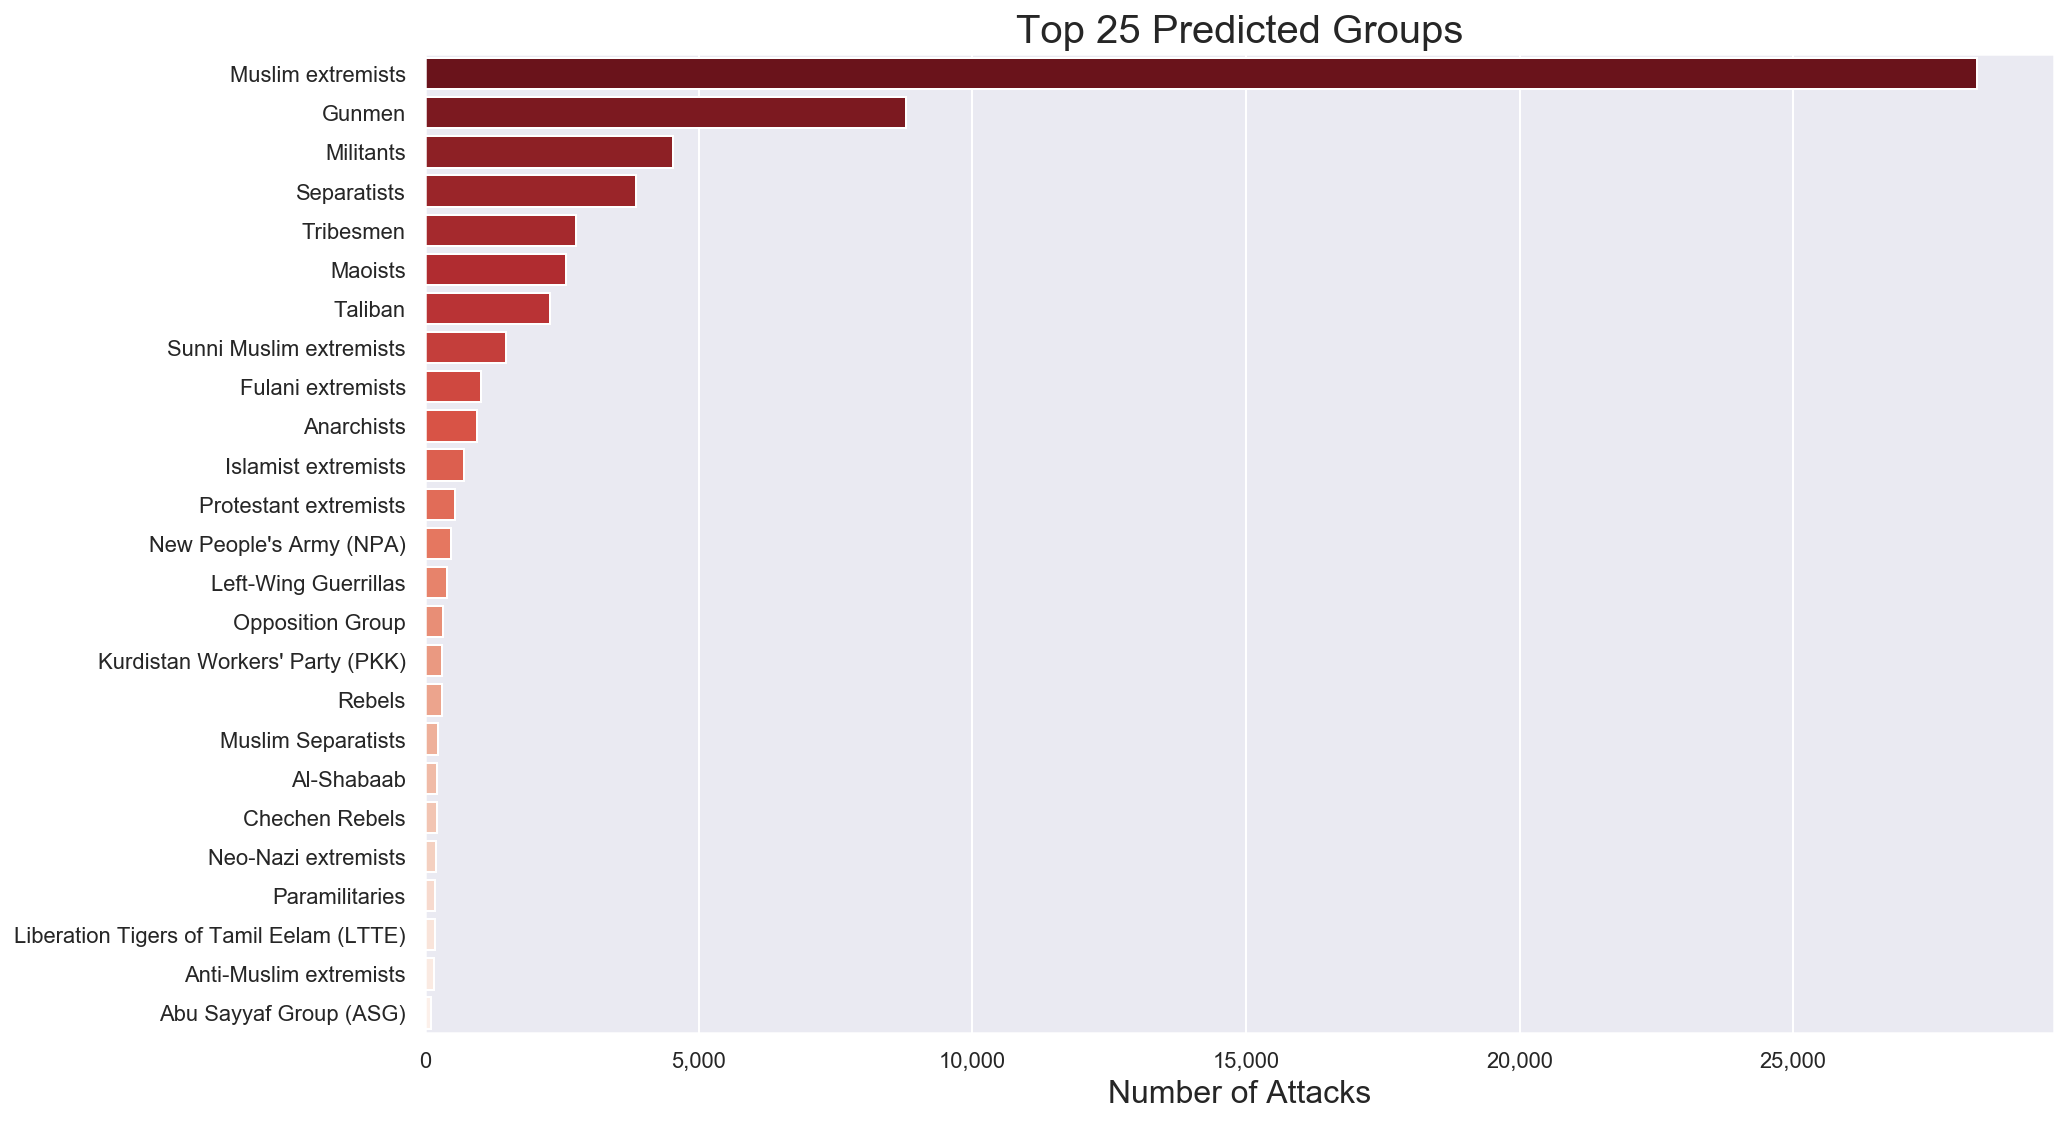

In [27]:
# Set the color palette in reverse
colors = sns.color_palette('Reds', len(unknown_top25))
colors.reverse()
plt.figure(figsize=(14.6, 9.0))

# Plot bar chart with index as y values
ax = sns.barplot(unknown_top25.Attacks, unknown_top25.index, orient='h', palette=colors)
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Reset the y labels
ax.set_yticklabels(unknown_top25.Group)
ax.set_xlabel(xlabel='Number of Attacks', fontsize=16)
ax.set_title(label='Top 25 Predicted Groups', fontsize=20)
plt.show();

### References

Albon, C. (2017). Convert Pandas categorical data for scikit-learn Retrieved from https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/

Keen, B. (2017). Feature scaling with scikit-learn Retrieved from http://benalexkeen.com/feature-scaling-with-scikit-learn/

Saabas, A. (2014). Selecting good features – Part III: random forests Retrieved from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

scikit-learn. (n.d.). Feature importances with forests of trees Retrieved from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py